In [3]:
from math import  floor,ceil

import torch
from torchvision.transforms import v2
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

from fft_conv2d import fft_conv2d, fft_inv_conv2d
    
def center_kernel(adjusted_kernel, original_k_shape, x_shape):
    original_k_shape = original_k_shape[2:]
    x_shape = x_shape[2:]
    k_rolling = (
        x_shape[0]//2,
        x_shape[1]//2,
    )
    dims = (2, 3)
    kernel_padded = adjusted_kernel.roll(k_rolling, dims=dims)
    kernel = kernel_padded.flip(dims)
    
    return kernel


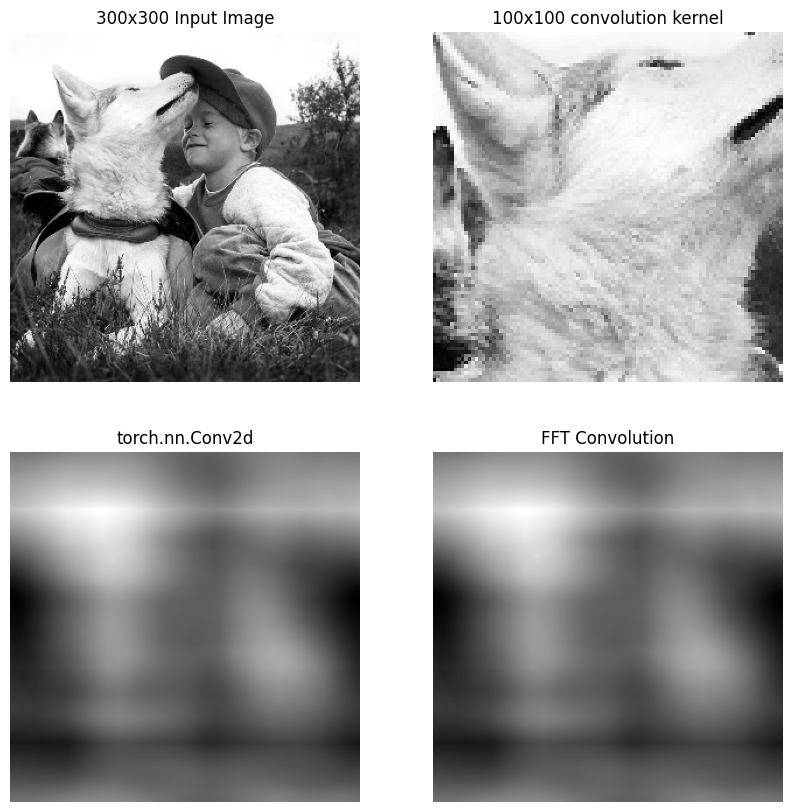

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#source: https://en.wikipedia.org/wiki/Dog#/media/File:Siberian_Husky_pho.jpg
image_path = "./data/Siberian_Husky_pho.jpg"
crop=700
image_size = 300
transform = v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True), 
        v2.Grayscale(num_output_channels=1),
        v2.CenterCrop(crop),
        v2.Resize(image_size),
    ])

image = transform(Image.open(image_path)).to(device)[None,:]

k = 100
conv_kernel = image[:,:, 40:140, 40:140]

torch_gauss_conv2d = torch.nn.Conv2d(1, 1, (k,k), padding="same", bias=False, padding_mode='circular', device=device)
torch_gauss_conv2d.weight.data = conv_kernel

image_torch_conv = torch_gauss_conv2d(image)
image_fft_conv = fft_conv2d(image, conv_kernel)

fig, axs = plt.subplots(2, 2, figsize=(10,10))
cmap="gray"
axs[0,0].imshow(image.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap)
axs[0,0].set_title(f"{image_size}x{image_size} Input Image")

axs[0,1].imshow(conv_kernel.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap)
axs[0,1].set_title(f"{k}x{k} convolution kernel")

cmap2="gray"
axs[1,0].imshow(image_torch_conv.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap2)
axs[1,0].set_title("torch.nn.Conv2d")

axs[1,1].imshow(image_fft_conv.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap2)#, norm=matplotlib.colors.LogNorm())
axs[1,1].set_title("FFT Convolution")

for ax in axs.flat:
    ax.axis('off')


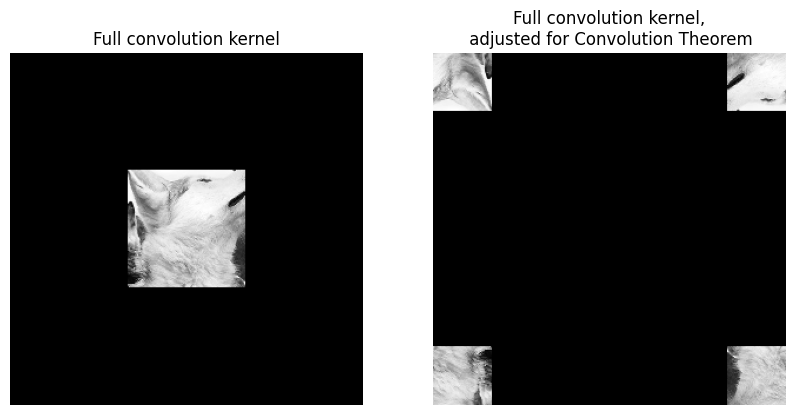

In [17]:
image_torch_conv_inv = fft_inv_conv2d(image_torch_conv, conv_kernel)
image_fft_conv_inv = fft_inv_conv2d(image_fft_conv, conv_kernel)

x_eye = torch.zeros_like(image)
x_eye[:,:,0,0] = 1.0
plot_torch_conv_kernel = torch.abs(fft_conv2d(x_eye, conv_kernel))
plot_intuitive_kernel = center_kernel(plot_torch_conv_kernel, conv_kernel.shape, image.shape)

fig, axs = plt.subplots(1, 2, figsize=(10,15))
cmap="gray"

axs[0].imshow(plot_intuitive_kernel.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap)
axs[0].set_title("Full convolution kernel")

axs[1].imshow(plot_torch_conv_kernel.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap)
axs[1].set_title("Full convolution kernel,\n adjusted for Convolution Theorem")

for ax in axs.flat:
    ax.axis('off')

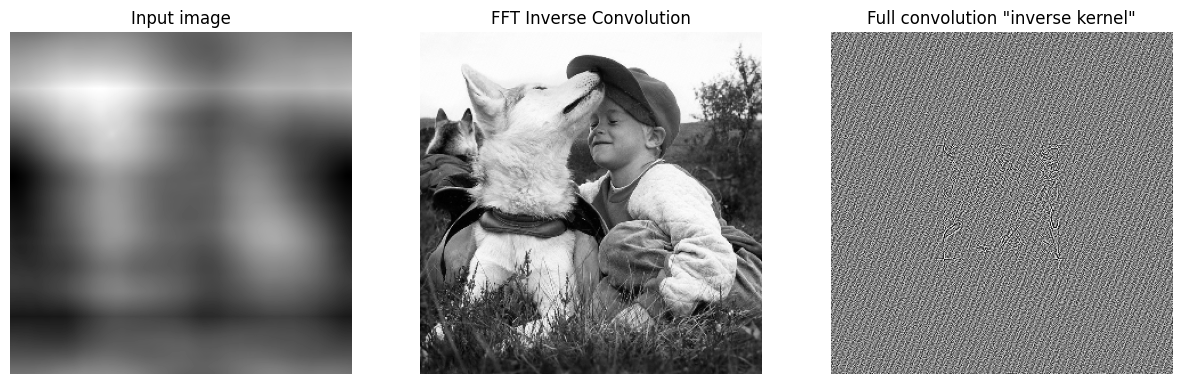

In [18]:


kernel_fft_conv_inv = center_kernel(fft_inv_conv2d(x_eye, conv_kernel), conv_kernel.shape, image.shape)

fig, axs = plt.subplots(1, 3, figsize=(15,20))
cmap="gray"
axs[0].imshow(image_torch_conv.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap)
axs[0].set_title(f"Input image")

axs[1].imshow(image_torch_conv_inv.detach().cpu()[0,:].permute(1, 2, 0), cmap=cmap)
axs[1].set_title("FFT Inverse Convolution")

xx=kernel_fft_conv_inv.detach().cpu()[0,:].permute(1, 2, 0)
xx = F.sigmoid(500*xx) #improves contrast for illustration purposes
axs[2].imshow(xx, cmap=cmap2)
axs[2].set_title("Full convolution \"inverse kernel\"")

for ax in axs.flat:
    ax.axis('off')
